# Imports

In [2]:
import matplotlib.pyplot as plt
from hypertiling import HyperbolicTiling, TilingKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.operators import adjacency
import networkx as nx
import numpy as np
from collections import defaultdict, deque
import pandas as pd
from math import gcd
from scipy.sparse.linalg import eigsh

c:\Users\17135\lattice_project\Hyperbolic_Lattices\hypertiling\check_numba.py:9: UserWarning: Failed to import numba... Use non-numba mode
  warnings.warn("Failed to import numba... Use non-numba mode")


# Create Hyperbolic Tiling Object

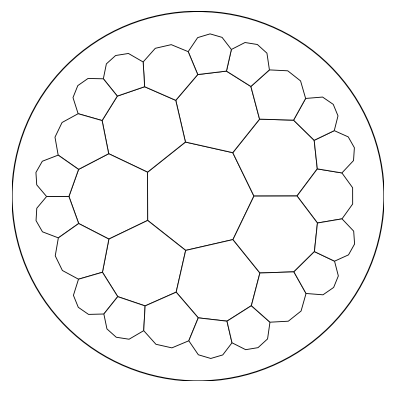

In [79]:
tiling = HyperbolicTiling(
    p=7, q=3, n=3,
    kernel=TilingKernels.StaticRotationalSector
)

plot_tiling(tiling, unitcircle=True, edgecolor="black", linewidth=0.5)
plt.show()

neighbors = tiling.get_nbrs_list(method="RO")

# Dual Graph and Spanning Tree

29


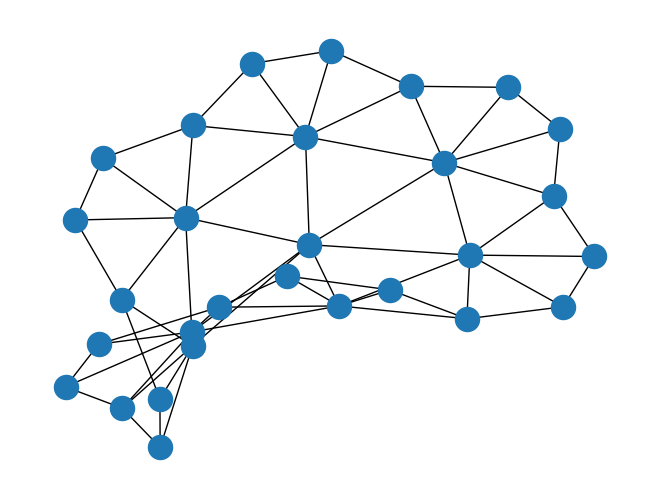

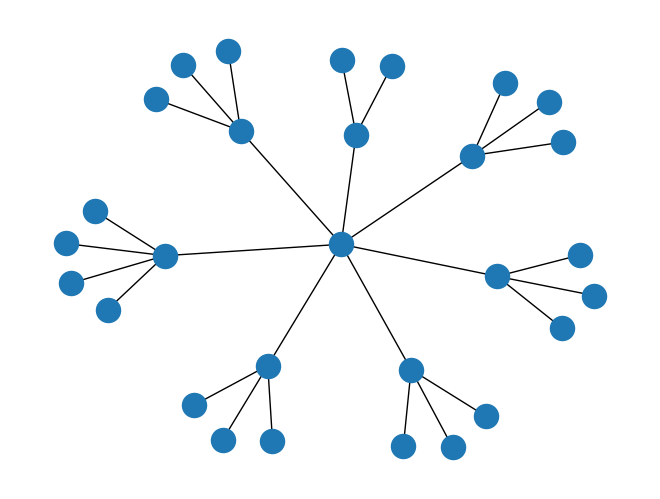

In [80]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
print(V)
G = nx.Graph()
for u, nbrs in enumerate(neighbors):
    for v in nbrs:
        if u < v:
            G.add_edge(u, v)
nx.draw(G)
plt.show()

# Get a spanning tree of G
T = nx.minimum_spanning_tree(G) 
nx.draw(T)
plt.show()
tree_edges = set(T.edges()) 


# Index Tiling Faces

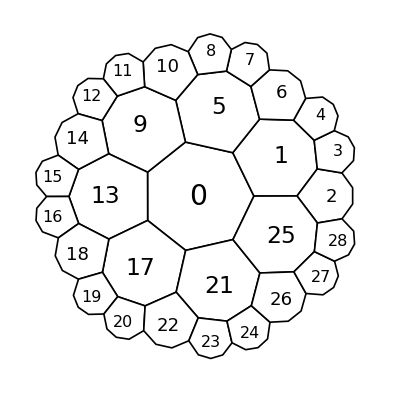

In [81]:
plot_tiling(tiling)
#layer_list = []
for poly in tiling.polygons:
    x, y = poly.get_center().real, poly.get_center().imag
    #layers = tiling.get_layer(poly)
    #layer_list.append(layers)
    plt.text(x, y, f"{poly.idx}", ha="center", va="center", fontsize=17*(1-0.7*np.abs(x*x+y*y)))
#print(layer_list)

# Notes

- need a way to make a list of each edge on the regular graph and find the intersections between the spanning tree 
- edges and the regular graph edges
- also need a way to take each face and find the regular graph edges that comprise the face cycle
- then we need to go back and figure out what multiplicities to assign to each spanning tree edge and also assign said multiplicity
- to the corresponding regular edge
- separately use coordinates to properly assign a sign -1 or +1 to each regular graph edge
- call this function within the multiplicity assigner for the regular graph and multiply with the sign
- call the multiplicities into the face cycles and then sum over everything + multiply by global phase
- this will be the total flux through the plaquette
- now check that this flux is equal to the global phase for each plaquette
- if correct, the adjacency matrix can be built and the butterfly should be accurate

# Extract Tiling Edges as a List

In [87]:
# First, we need to extract a list of edges for the regular tiling
edges = []
face_cycles = []
# iterate over cells
for poly in tiling:
    # extract vertex coordinates
    u = poly[1:]
    nv = len(u)
   
# loop over vertices/edges
    face_cycle_i = []
    for i in range(nv):
            # extract edges
            z1 = u[i]
            z2 = u[(i + 1) % tiling.p]
            edge = (z1, z2)
            edges.append(edge) 
            face_cycle_i.append(edge)
    face_cycles.append(face_cycle_i)
    print(len(face_cycle_i))
print(len(face_cycles))

print(len(edges))
# this inherently uses the coordinates of each vertex - relate them to the indices i assigned for brevity
# these coordinates are also key for designating the +/- sign later 
# the length of each face cycle should be 7. 29 face cycles of 7 edges each for 203 edges total
# now I need to connect the edges contributing to each face cycle with the tuples based on the face index

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
29
203


# Match Spanning Tree Node Indices to that of Tiling Faces

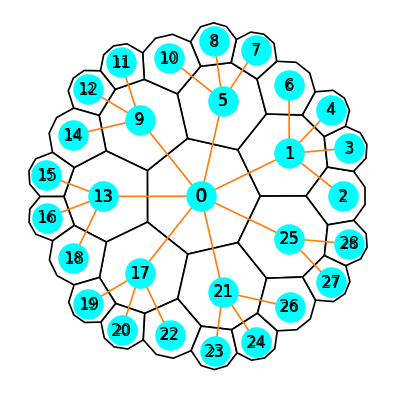

In [63]:
# Find a way to assign the vertices of the spanning tree the same index as the faces on the tiling 

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes
pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()


# Notes

In [124]:
# Now, I need to recursively define multiplicities associated with each edge of the spanning tree
# Then, I need to make sure that these multiplicities are associated with the right tiling edge
# After that, I need to pass that information into the face cycles so that I can obtain flux per plaquette

# Match Node/Face Indices to the Corresponding Layer of the Tiling 

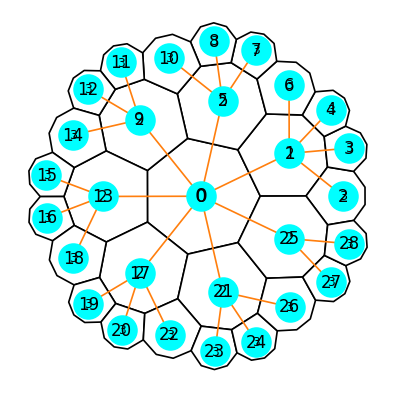

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28)]


In [64]:
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)


# Notes

In [145]:
# For each face cycle, we can describe the associated edges via the coordinates of the tiling's vertices
# We need to then find out the index of the two faces on either side of each of the face cycle edges
# For example, if E1 is an edge in the regular tiling and is part of the face cycle for both face 1 and face 3
# then I know that faces 1 and 3 are adjacent and there must exist an edge on the dual graph such that it is
# described by nodes 1 and 3 (ie. we pick out edge (1,3) or (3,1)). 
# this means we can correlate the tiling edges to dual graph edges within a list of tuples
# then iterate through each combination to build a new list that only contains tuples where the dual graph edge
# component is ALSO part of the spanning tree
# this new list will have tuples containing BOTH the edges of the spanning tree 
# and the edges of the tiling which they intersect with

# suppose we have another function that assigns a value to each spanning tree edge and multiplies it by phi
# now it would be easy to relate that information to the tiling edges by adding an element to the tuples
# each component of the list would now look like (tiling edge, ST edge, #phi)
# then somehow rebuild the face cycles including the #phi value
# sum over all #phi for each face cycle
# verify that the total matches for all face cycles
# build hamiltonian and butterfly

In [146]:
# since each tiling edge is written in terms of the coordinates of the vertices, 
# there should be a way to find the neighbors of each edge? - check package
# then, I should be able to figure out which faces are being glued together by each edge

# need a pandas data frame to store all this information because it's way too much stuff overall 

The information I need/have:

- list of the faces (their index)
- each face cycle
- list of the spanning tree nodes (indexed the same way as the faces)
- which layer each face belongs to
- the value associated with each spanning tree edge
- list of all the spanning tree edges
- list of all the dual graph edges (this information does not need to be stored permanently)


# Add Root to Spanning Tree

Graph with 30 nodes and 29 edges


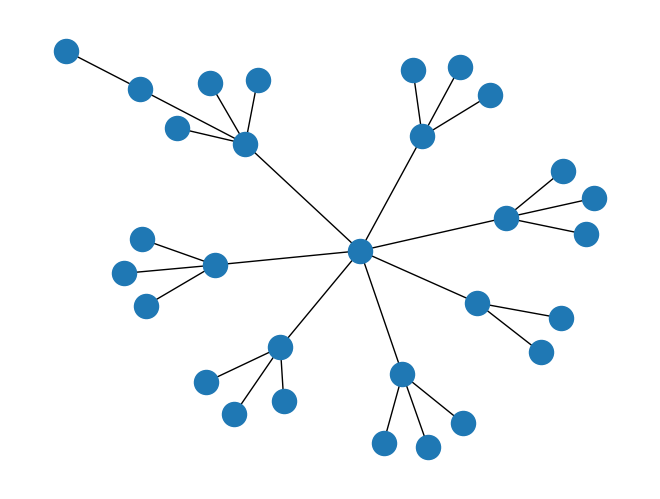

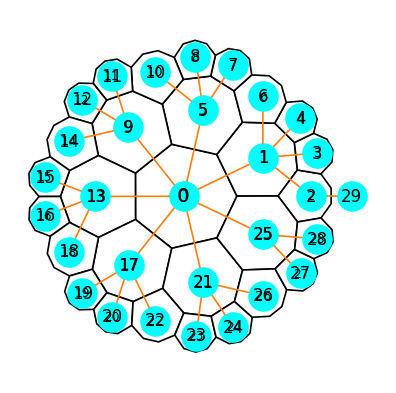

In [65]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
root_point = V

# p determines the number of edges each polygon face has, and every face will have p neighbors
# however, the faces on the outer ring will have p-1 neighbors, so if nbrs < p, said face is on the boundary
outermost_faces = []
for u, nbrs in enumerate(neighbors):
    if len(nbrs) < tiling.p:
        outermost_faces.append(u)
root_face = outermost_faces[0]

# Get a spanning tree of G
T_rooted = nx.minimum_spanning_tree(G)

T_rooted.add_edge(root_face, root_point)
tree_edges_rooted = set(T_rooted.edges()) 
print(T_rooted)
nx.draw(T_rooted)
plt.show()

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

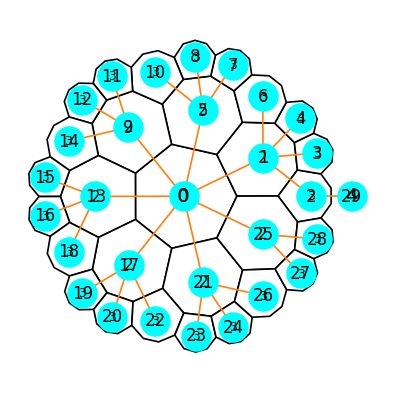

[0, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[(0, 0), (2, 1), (3, 2), (3, 3), (3, 4), (2, 5), (3, 6), (3, 7), (3, 8), (2, 9), (3, 10), (3, 11), (3, 12), (2, 13), (3, 14), (3, 15), (3, 16), (2, 17), (3, 18), (3, 19), (3, 20), (2, 21), (3, 22), (3, 23), (3, 24), (2, 25), (3, 26), (3, 27), (3, 28), (4, 29)]


In [66]:
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

outer_layer = tiling.n + 1
layers_list.append(outer_layer)
poly_list.append(root_point)

x, y = pos[root_point]
plt.text(x, y, str(outer_layer),
         ha="center", va="center",
         fontsize=12)

# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

print(layers_list)
print(poly_list)
layer_plus_poly = list(zip(layers_list, poly_list))
print(layer_plus_poly)

In [67]:
import pandas as pd

faces_nodes_layers_df = pd.DataFrame({
    "Tiling Faces/ST Nodes Index": poly_list,
    "Layer": layers_list
})

print(faces_nodes_layers_df)


    Tiling Faces/ST Nodes Index  Layer
0                             0      0
1                             1      2
2                             2      3
3                             3      3
4                             4      3
5                             5      2
6                             6      3
7                             7      3
8                             8      3
9                             9      2
10                           10      3
11                           11      3
12                           12      3
13                           13      2
14                           14      3
15                           15      3
16                           16      3
17                           17      2
18                           18      3
19                           19      3
20                           20      3
21                           21      2
22                           22      3
23                           23      3
24                       

In [69]:
print(tree_edges_rooted) # includes all the edges of the spanning tree + artificial root

node_to_layer = dict(zip(
    faces_nodes_layers_df["Tiling Faces/ST Nodes Index"],
    faces_nodes_layers_df["Layer"]
))

# relabel edges (u, v) → (layer(u), layer(v))
tree_edges_layers = [(node_to_layer[u], node_to_layer[v]) for (u, v) in tree_edges_rooted]
print(tree_edges_layers)

edges_df = pd.DataFrame(tree_edges_rooted, columns=["u", "v"])
edges_df["layer_u"] = edges_df["u"].map(node_to_layer).astype(int)
edges_df["layer_v"] = edges_df["v"].map(node_to_layer).astype(int)
print(edges_df)


{(5, 7), (5, 10), (0, 5), (9, 14), (9, 11), (1, 6), (1, 3), (0, 17), (25, 28), (2, 29), (21, 24), (0, 1), (1, 2), (17, 20), (0, 13), (13, 16), (0, 25), (25, 27), (21, 23), (21, 26), (5, 8), (9, 12), (0, 9), (17, 19), (1, 4), (17, 22), (0, 21), (13, 18), (13, 15)}
[(2, 3), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (3, 4), (2, 3), (0, 2), (2, 3), (2, 3), (0, 2), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (2, 3), (2, 3), (0, 2), (2, 3), (2, 3)]
     u   v  layer_u  layer_v
0    5   7        2        3
1    5  10        2        3
2    0   5        0        2
3    9  14        2        3
4    9  11        2        3
5    1   6        2        3
6    1   3        2        3
7    0  17        0        2
8   25  28        2        3
9    2  29        3        4
10  21  24        2        3
11   0   1        0        2
12   1   2        2        3
13  17  20        2        3
14   0  13        0        2
15  13  16        2        3
16   0  25

# Multiplicity Attempt 2

In [ ]:
def assign_edge_multiplicities_shallow(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy()

    root_layer  = int(df["layer_v"].max())
    outer_layer = root_layer - 1

    # faces directly connected to the root
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy()))
    multiplicity = {}

    # Base: edges whose parent is on outer_layer → multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]]
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # Children index: edges grouped by their CHILD (u)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # One step inward: parent at (outer_layer - 1)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_cur = row["v"]
        kids = child_index.get(v_cur, [])      # edges with u == v_cur (the outward children)
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]]

    # --- NEW: collect grandchildren for each root-layer edge (kept in df.attrs) ---
    grandchildren_by_root_edge = {}
    grandchildren_by_child_edge = {}
    # ------------------------------------------------------------------------------

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        m_root = v_root
        multiplicity[e_root] = m_root

        # the edge whose parent equals this u (v == u0): multiplicity = m_root - 1
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            # In a tree there should be at most one; if multiple, take the first
            e_child = child_rows.iloc[0]["edge"]
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root

            # --- NEW: grandchildren of that chosen child edge (two steps from root) ---
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges
            # --------------------------------------------------------------------------

    # --- NEW: store results without changing return columns ---
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge
    # ----------------------------------------------------------

    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    return df.drop(columns=["edge"])

edges_with_mult = assign_edge_multiplicities_shallow(edges_df)

# All grandchildren (list of edges) per root-layer edge:
gc_by_root = edges_with_mult.attrs["grandchildren_by_root_edge"]

# Or keyed by the chosen child edge (the one used in your loop):
gc_by_child = edges_with_mult.attrs["grandchildren_by_child_edge"]

print(edges_with_mult)
print(gc_by_root)
print(gc_by_child)

     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2             4
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1
20   5   8        2        3             1
21   9  12        2        3             1
22   0   9 

# Successful Multiplicity Assigner

In [71]:
def assign_edge_multiplicities(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy() # the data frame contains the ST edges in terms of face indices and their tiling layer
    # each edge's data is contained in a row in this df - aim is to add the multiplicity value associated with every edge
    # to the df - this value represents the number of times the ST edge crosses its corresponding tiling edge
    # and will eventually be ascribed to that tiling edge
    root_layer  = int(df["layer_v"].max()) # when I added the artificial root, I assigned this node a tiling layer of
    # value n + 1 where n is the layer of the edge tiles (hence the next line)
    # for this line, I just pulled the maximum value of the tiling layers from the df since that has to be the root layer
    outer_layer = root_layer - 1

    # first, I want to start from the outer layer and go to the next layer. in doing so, I will traverse ST edges, and 
    # I know for a fact that all of these edges should be ascribed a multiplicity of 1
    # however, there is a chain of faces and ST edges that connects from the root layer to the center tile
    # I want to exclude assigning a multiplicity of 1 to the outer tile to next layer ST edge where the 
    # outer tile is connected to the root node, because that would be annoying to correct later
    # thus, I exclude the face directly connected to the root during this first round assignment
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy())) # from df, extract edges as tuples for ease
    multiplicity = {} # empty dict for multiplicities to be added to df later

    # the hierarchy is: root_edge (not really part of the ST), parent edges (edges from outer faces to the next layer)
    # then children edges (in (u,v), u is the child, and the child edge is (u',v') st. v' = u) 
    # the "parent" is the v in (u,v) since it defines the layer (layer_u, layer_v) from which the edge goes further into the tiling

    # Round 1 - Base: edges whose parent is on outer_layer given multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]] # define edges that will be given multiplicity = 1
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # define edges grouped by the children of the base edge parents (we had (u,v) given 1, and now we want to find 
    # all the edges (u',v' = u) since they are children edges going from layer n to n-1)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # Round 2 - one step inward: parent at (outer_layer - 1) (u is now the parent)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_current = row["v"]
        children = child_index.get(v_current, [])      # edges with u == v_current 
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in children) + 1
        # I need to sum the multiplicities of the previous base edges associated with u to get the multiplicity
        # of the edge who's parent  is u

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]] # all the data tracing back to root

    # grandchildren from the root are the children of the parent edge
    # grandchildren from the child edge are in the case of the tiling im using, the last layer of edges
    grandchildren_by_root_edge = {} 
    grandchildren_by_child_edge = {}

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        # basically, now I am assigning a multiplicity to the root edge and I know it should be equal to the number of faces
        # so since I made the index of the root node 1 + the highest, and python iterates from zero, it's index value should be
        # exactly the multiplicity it needs to be assigned
        m_root = v_root
        multiplicity[e_root] = m_root
        # now I want to go to the next edge connected to the root edge and assign it's multiplicity as  +(-1) of the previous
        # the edge whose parent equals this u (v == u0) has multiplicity = m_root - 1
        # I grab this edge by just finding which child edge I have not yet assigned a multiplicity to yet
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            e_child = child_rows.iloc[0]["edge"] # ^that edge
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root # just for safety

            # grandchildren (two steps from root)
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges

    # finalize multiplicities - make sure the sums update since all the multiplicities are filled now
    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    # in particular, the grandchild of the root has a value from the sums, but it is not accurate since
    # we hadn't assigned the root or root child multiplicities before - gotta update this as -sum + root child
    # overwrite the single grandchild multiplicity using the child edge multiplicity
    try:
        gc_root_flat = [e for lst in grandchildren_by_root_edge.values() for e in lst]
        gc_child_flat = [e for lst in grandchildren_by_child_edge.values() for e in lst]
        if len(gc_root_flat) == 1 and gc_root_flat == gc_child_flat:
            gc_edge = gc_root_flat[0]

            # find the unique child edge associated with this grandchild
            child_candidates = [ec for ec, lst in grandchildren_by_child_edge.items() if gc_edge in lst]
            if child_candidates:
                e_child_edge = child_candidates[0]

                # original grandchild multiplicity X
                u_gc, v_gc = gc_edge
                m_gc_old = int(df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"].iloc[0])

                # child edge multiplicity
                u_ch, v_ch = e_child_edge
                m_child = int(df.loc[(df["u"] == u_ch) & (df["v"] == v_ch), "multiplicity"].iloc[0])

                # overwrite new_multiplicity = -(X) + m_child
                new_m = int(-m_gc_old + m_child)

                # apply to df
                df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"] = new_m
                multiplicity[gc_edge] = new_m
                # check to see if it worked
                print(
                    f"Grandchild edge {gc_edge} multiplicity updated: "
                    f"old={m_gc_old}, child edge {e_child_edge} had multiplicity={m_child}, new={new_m}"
                )
    except Exception:
        pass # safety

    # keep grandchildren 2 ways as a consistency check - not included in final df
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge

    return df.drop(columns=["edge"])
edges_with_mult = assign_edge_multiplicities(edges_df)
print(edges_with_mult)

Grandchild edge (0, 1) multiplicity updated: old=4, child edge (1, 2) had multiplicity=28, new=24
     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2            24
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1

Attempt to relate each ST edge to the edge of the tiling it crosses

In [ ]:
def _vkey(z, ndigits=12):
    if isinstance(z, complex):
        return (round(z.real, ndigits), round(z.imag, ndigits))
    x, y = z
    return (round(x, ndigits), round(y, ndigits))

def _get_vertices(poly):
    if hasattr(poly, "get_vertices"):
        return list(poly.get_vertices())
    try:
        return list(poly[1:])
    except Exception:
        raise TypeError("Add a branch to extract vertices for your polygon type.")

# relate the ST edges (written in terms of face indices) to the tiling edges they cross
# store each edge that crosses the boundary to the root face as well
def build_facepair_to_coords(tiling, ndigits=12, *, include_boundary=True, root_id=-1):
    vertex_id, id_vertex = {}, []
    def get_vid(z):
        k = _vkey(z, ndigits)
        if k not in vertex_id:
            vertex_id[k] = len(id_vertex)
            id_vertex.append(z)
        return vertex_id[k]

    def undir(a, b): return (a, b) if a < b else (b, a)

    edge_to_faces = defaultdict(list)   
    edge_to_coords = {}                 

    for poly in tiling.polygons:
        f = int(poly.idx)
        verts = _get_vertices(poly)
        vids  = [get_vid(z) for z in verts]
        nv = len(vids)
        for i in range(nv):
            a, b = vids[i], vids[(i+1) % nv]
            key = undir(a, b)
            if key not in edge_to_coords:
                z1, z2 = id_vertex[key[0]], id_vertex[key[1]]
                edge_to_coords[key] = (z1, z2)
            edge_to_faces[key].append(f)

    facepair_to_coords = {}
    for key, faces in edge_to_faces.items():
        if len(faces) == 2:
            f1, f2 = int(faces[0]), int(faces[1])
            facepair_to_coords[frozenset({f1, f2})] = edge_to_coords[key]
        elif include_boundary and len(faces) == 1:
            f = int(faces[0])
            facepair_to_coords[frozenset({f, int(root_id)})] = edge_to_coords[key]
      

    return facepair_to_coords

# attach (z1, z2) to each (u, v) row in the df
def attach_coords_by_facepair(df, facepair_to_coords, *, root_id=-1, drop_unmatched=False):
    out = df.copy()
    # ensure that the data type is all integers
    if out["u"].dtype != int: out["u"] = out["u"].astype(int)
    if out["v"].dtype != int: out["v"] = out["v"].astype(int)

    def lookup(row):
        key = frozenset({row["u"], row["v"]})
        return facepair_to_coords.get(key, (None, None))

    zcols = out.apply(lookup, axis=1, result_type="expand")
    zcols.columns = ["edge_z1", "edge_z2"]
    out = pd.concat([out, zcols], axis=1)

    # check to make sure all the ST edges have a match
    missing = int(out["edge_z1"].isna().sum())
    if missing:
        print(f"Note: {missing} edges had no matching tiling edge ")

    if drop_unmatched:
        out = out[out["edge_z1"].notna()].reset_index(drop=True)

    return out
root_point = V
facepair_to_coords = build_facepair_to_coords(tiling, ndigits=12, include_boundary=True, root_id=root_point)
edges_with_geom = attach_coords_by_facepair(edges_with_mult, facepair_to_coords, root_id=root_point)

print(edges_with_geom)


     u   v  layer_u  layer_v  multiplicity             edge_z1  \
0    5   7        2        3             1  0.284345+0.593718j   
1    5  10        2        3             1 -0.001418+0.658294j   
2    0   5        0        2             4  0.187003+0.235534j   
3    9  14        2        3             1 -0.515560+0.409331j   
4    9  11        2        3             1 -0.286901+0.592487j   
5    1   6        2        3             1  0.513791+0.411549j   
6    1   3        2        3             1  0.641474+0.147867j   
7    0  17        0        2             4 -0.270678-0.131071j   
8   25  28        2        3             1  0.642105-0.145101j   
9    2  29        3        4            29  0.831342+0.045802j   
10  21  24        2        3             1  0.155885-0.676255j   
11   0   1        0        2            24  0.300742+0.000648j   
12   1   2        2        3            28  0.532381+0.001147j   
13  17  20        2        3             1 -0.431525-0.543514j   
14   0  13

In [ ]:
def vkey(z, ndigits=12):
    if isinstance(z, complex):
        return (round(z.real, ndigits), round(z.imag, ndigits))
    else:
        x, y = z
        return (round(x, ndigits), round(y, ndigits))

def get_vertices(poly):
    return list(poly.get_vertices()) if hasattr(poly, "get_vertices") else list(poly[1:])

def build_vid_map(tiling, ndigits=12):
    vid = {}
    idv = []
    def get_vid(z):
        k = vkey(z, ndigits)
        if k not in vid:
            vid[k] = len(idv)
            idv.append(z)
        return vid[k]
    return get_vid

def undir_key_by_vid(z1, z2, get_vid):
    a, b = get_vid(z1), get_vid(z2)
    return (a, b) if a < b else (b, a)

def multiplicity_map_from_df(df, get_vid):
    mult = defaultdict(int)
    for _, r in df.iterrows():
        z1, z2 = r.get("edge_z1"), r.get("edge_z2")
        if z1 is None or z2 is None or pd.isna(z1) or pd.isna(z2):
            continue
        key = undir_key_by_vid(z1, z2, get_vid)
        mult[key] += int(r["multiplicity"])
    return mult

def face_cycles_sign_propagation(tiling, edges_df_with_geom, ndigits=12):
    get_vid = build_vid_map(tiling, ndigits=ndigits)
    mult_map = multiplicity_map_from_df(edges_df_with_geom, get_vid) 

    polys = getattr(tiling, "polygons", tiling)
    faces = []
    face_edges = {}        
    edge_to_faces = defaultdict(list)
    for poly in polys:
        fidx = int(getattr(poly, "idx", None) if hasattr(poly, "idx") else len(faces))
        faces.append(fidx)
        verts = get_vertices(poly)
        nv = len(verts)
        keys = []
        for i in range(nv):
            k = undir_key_by_vid(verts[i], verts[(i+1) % nv], get_vid)
            keys.append(k)
            if mult_map.get(k, 0) != 0:
                edge_to_faces[k].append(fidx)
        face_edges[fidx] = keys

    def nz_edges(f):
        return [(k, mult_map.get(k, 0)) for k in face_edges[f] if mult_map.get(k, 0) != 0]

    outer_faces = [f for f in faces if len(nz_edges(f)) == 1]
    outer_root_face = None
    for f in faces:
        nz = nz_edges(f)
        if len(nz) == 2 and any(len(edge_to_faces[k]) == 1 for k, _ in nz):
            outer_root_face = f
            break  

    # sign assignments
    sign = {}

    q = deque()

    for f in outer_faces:
        k, _m = nz_edges(f)[0]
        if (f, k) not in sign:
            sign[(f, k)] = +1
            q.append(f)

    if outer_root_face is not None:
        pairs = nz_edges(outer_root_face)  # [(k1,m1),(k2,m2)]
        (k_pos, _), (k_neg, _) = (pairs[0], pairs[1]) if pairs[0][1] >= pairs[1][1] else (pairs[1], pairs[0])
        if (outer_root_face, k_pos) not in sign:
            sign[(outer_root_face, k_pos)] = +1
        if (outer_root_face, k_neg) not in sign:
            sign[(outer_root_face, k_neg)] = -1
        q.append(outer_root_face)

    # boundary matching
    def push_boundary_constraints(f):
        changed = False
        for k, m in nz_edges(f):
            if (f, k) not in sign:
                continue
            s = sign[(f, k)]
            for g in edge_to_faces.get(k, []):
                if g == f:
                    continue
                if (g, k) not in sign:
                    sign[(g, k)] = -s
                    q.append(g)
                    changed = True
        return changed

    # complete a face by using the "sum == 1" rule if only one unknown remains
    def complete_face_if_one_unknown(f):
        # collect nonzero edges and their current signed contributions
        nz = [(k, mult_map[k]) for k in face_edges[f] if mult_map.get(k, 0) != 0]
        unknown = []
        known_sum = 0
        for k, m in nz:
            s = sign.get((f, k))
            if s is None:
                unknown.append((k, m))
            else:
                known_sum += s * m
        if len(unknown) == 1:
            k, m = unknown[0]
            # choose s so that known_sum + s*m = 1  => s = sign(1 - known_sum), but constrain to ±1
            residual = 1 - known_sum
            s = +1 if residual >= 0 else -1
            sign[(f, k)] = s
            q.append(f)  
            return True
        return False

    # main propagation loop
    while q:
        f = q.popleft()
        pushed = push_boundary_constraints(f)
        # finish this face by sum==1
        completed = complete_face_if_one_unknown(f)
        # push boundary constraints again so neighbors get updated
        if completed:
            push_boundary_constraints(f)

    # build face lists
    result = {}
    for f in faces:
        lst = []
        for k in face_edges[f]:
            m = mult_map.get(k, 0)
            if m == 0:
                lst.append(0)
            else:
                s = sign.get((f, k))
                lst.append((s if s is not None else +1) * m)
        result[f] = lst

    return result

# print all the face cycles in terms of the multiplicity associated with the edges and the proper sign
# sum each face cycle to ensure the flux through each plaquette is uniform
face_cycles_signed = face_cycles_sign_propagation(tiling, edges_with_geom, ndigits=12)

all_ok = True
for fidx in sorted(face_cycles_signed.keys()):
    row = face_cycles_signed[fidx]
    s = sum(row)
    print(f"face cycle {fidx}: {row}   (sum={s})")
    if s != 1:
        all_ok = False

if not all_ok:
    print("Some face-cycles have sums ≠ 1")


face cycle 0: [24, -4, -4, -4, -4, -4, -3]   (sum=1)
face cycle 1: [0, 28, -1, -1, -1, 0, -24]   (sum=1)
face cycle 2: [-28, 0, 0, 0, 0, 29, 0]   (sum=1)
face cycle 3: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 4: [0, 0, 1, 0, 0, 0, 0]   (sum=1)
face cycle 5: [0, 0, -1, -1, -1, 0, 4]   (sum=1)
face cycle 6: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 7: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 8: [0, 0, 1, 0, 0, 0, 0]   (sum=1)
face cycle 9: [0, 0, -1, -1, -1, 0, 4]   (sum=1)
face cycle 10: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 11: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 12: [0, 0, 1, 0, 0, 0, 0]   (sum=1)
face cycle 13: [0, 0, -1, -1, -1, 0, 4]   (sum=1)
face cycle 14: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 15: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 16: [0, 0, 1, 0, 0, 0, 0]   (sum=1)
face cycle 17: [0, 0, -1, -1, -1, 0, 4]   (sum=1)
face cycle 18: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 19: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 20: [0, 0, 1, 0, 0, 0, 0]   (su

C:\Users\17135\AppData\Local\Temp\ipykernel_26156\2576925924.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  mult[key] += int(r["multiplicity"])


# Final Product

Ok, now that all the components are ready, I just need to clean everything up and organize it so that I can effectively compute the butterfly. 

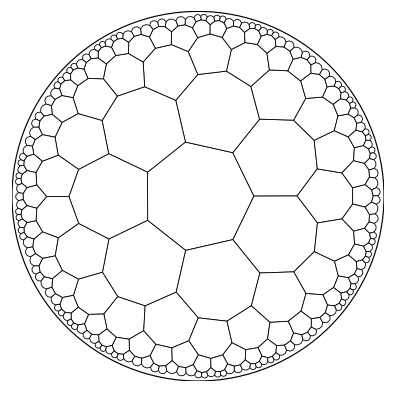

In [267]:
# Step 1: Create the hyperbolic tiling 

tiling = HyperbolicTiling(
    p=7, q=3, n=5,
    kernel=TilingKernels.StaticRotationalSector
)

plot_tiling(tiling, unitcircle=True, edgecolor="black", linewidth=0.5)
plt.show()

neighbors = tiling.get_nbrs_list(method="RO")

232


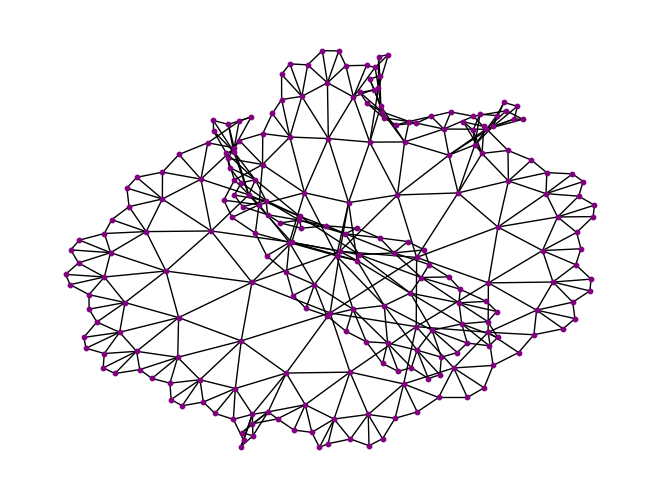

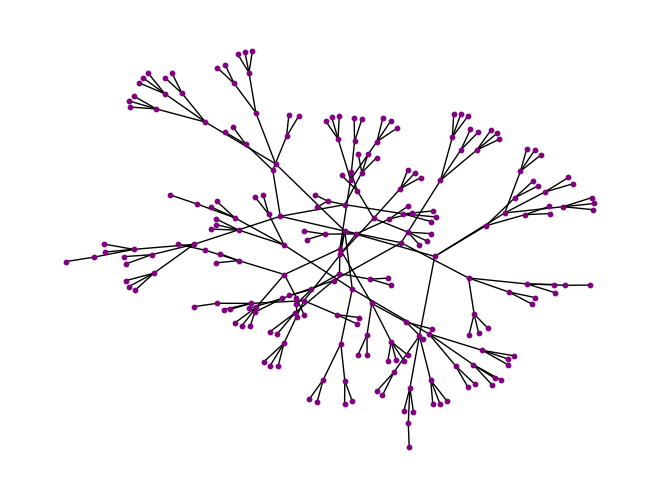

In [268]:
# Step 2: Create a dual graph and spanning tree for this tiling

options = {
    'node_color': 'purple',
    'node_size': 10,
    'width': 1,
}

V = len(tiling) # vertices = number of faces
print(V)
G = nx.Graph()
for u, nbrs in enumerate(neighbors):
    for v in nbrs:
        if u < v:
            G.add_edge(u, v)
nx.draw(G, **options)
plt.show()

# Get a spanning tree of G
T = nx.minimum_spanning_tree(G) 
nx.draw(T, **options)
plt.show()
tree_edges = set(T.edges()) 

In [269]:
# Step 3: Create a list of face cycles and edges for this tiling

# First, we need to extract a list of edges for the regular tiling
edges = []
face_cycles = []
# iterate over cells
for poly in tiling:
    # extract vertex coordinates
    u = poly[1:]
    nv = len(u)
   
# loop over vertices/edges
    face_cycle_i = []
    for i in range(nv):
            # extract edges
            z1 = u[i]
            z2 = u[(i + 1) % tiling.p]
            edge = (z1, z2)
            edges.append(edge) 
            face_cycle_i.append(edge)
    face_cycles.append(face_cycle_i)
    print(len(face_cycle_i))
print(len(face_cycles))

print(len(edges))
# this inherently uses the coordinates of each vertex - relate them to the indices i assigned for brevity

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
232
1624


Graph with 233 nodes and 232 edges


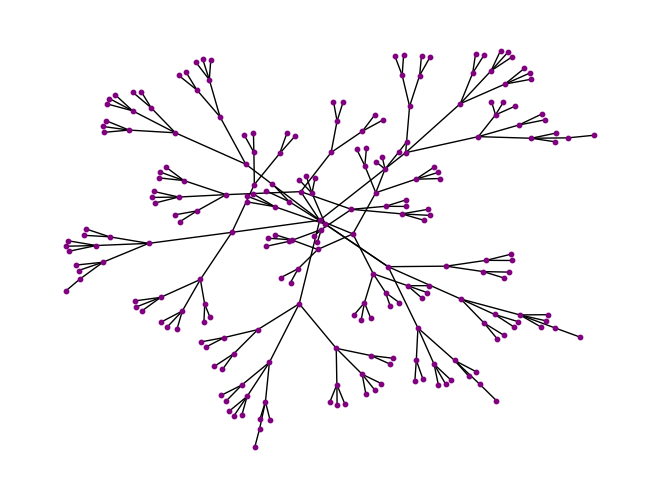

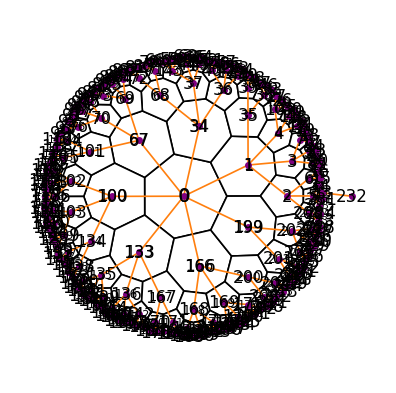

In [270]:
# Step 4: Add root to the tiling and match up the face indices to the indices of ST nodes

# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
root_point = V

# p determines the number of edges each polygon face has, and every face will have p neighbors
# however, the faces on the outer ring will have p-1 neighbors, so if nbrs < p, said face is on the boundary
outermost_faces = []
for u, nbrs in enumerate(neighbors):
    if len(nbrs) < tiling.p:
        outermost_faces.append(u)
root_face = outermost_faces[0]

# Get a spanning tree of G
T_rooted = nx.minimum_spanning_tree(G)

T_rooted.add_edge(root_face, root_point)
tree_edges_rooted = set(T_rooted.edges()) 
print(T_rooted)
nx.draw(T_rooted, **options)
plt.show()

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, **options, pos=pos,
        with_labels=True,
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

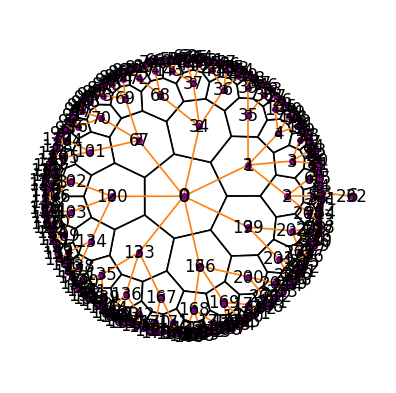

[(4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (2, 3), (3, 4), (4, 5), (4, 5), (0, 2), (4, 5), (4, 5), (4, 5), (4, 5), (2, 3), (3, 4), (4, 5), (4, 5), (3, 4), (4, 5), (4, 5), (4, 5), (3, 4), (4, 5), (2, 3), (3, 4), (0, 2), (4, 5), (4, 5), (3, 4), (4, 5), (3, 4), (4, 5), (2, 3), (3, 4), (4, 5), (2, 3), (3, 4), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (3, 4), (4, 5), (2, 3), (3, 4), (4, 5), (4, 5), (4, 5), (3, 4), (4, 5), (3, 4), (4, 5), (2, 3), (3, 4), (4, 5), (4, 5), (4, 5), (2, 3), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (3, 4), (4, 5), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (4, 5), (5, 5), (4, 5), (3, 4), (4, 5), (0, 2), (4, 5), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (5, 5), (4, 5), (4, 5), (3, 4), (4, 5), (4, 5), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (5, 5), (4, 5), (4, 5), (3, 4), (4, 5), (2, 3), (0, 2), (4, 5), (4, 5), (3, 4), (3, 4), (4, 5), (4, 5), (4, 5), (4, 5), (5, 5), (3, 4), (3, 4),

In [271]:
# Step 5: Find the tiling layer associated with each face and organize all the information collected
# thus far into a data frame to be manipulated later

T_idx = nx.Graph()
for u, v in T_rooted.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

layers_list = []
poly_list = []
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    layers_list.append(l)
    poly_list.append(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = {node: (poly_map[node].get_center().real,
              poly_map[node].get_center().imag)
       for node in T_idx.nodes() if node in poly_map}

# now add the outside node explicitly
max_r = max(abs(poly.get_center()) for poly in tiling.polygons)
pos[root_point] = (1.2 * max_r, 0)

outer_layer = tiling.n + 1
layers_list.append(outer_layer)
poly_list.append(root_point)

x, y = pos[root_point]
plt.text(x, y, str(outer_layer),
         ha="center", va="center",
         fontsize=12)

# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, **options, pos=pos,
        with_labels=True,
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()

layer_plus_poly = list(zip(layers_list, poly_list))


faces_nodes_layers_df = pd.DataFrame({
    "Tiling Faces/ST Nodes Index": poly_list,
    "Layer": layers_list
})

node_to_layer = dict(zip(
    faces_nodes_layers_df["Tiling Faces/ST Nodes Index"],
    faces_nodes_layers_df["Layer"]
))

# relabel edges (u, v) → (layer(u), layer(v))
tree_edges_layers = [(node_to_layer[u], node_to_layer[v]) for (u, v) in tree_edges_rooted]
print(tree_edges_layers)

edges_df = pd.DataFrame(tree_edges_rooted, columns=["u", "v"])
edges_df["layer_u"] = edges_df["u"].map(node_to_layer).astype(int)
edges_df["layer_v"] = edges_df["v"].map(node_to_layer).astype(int)

#from pathlib import Path

#path = Path("edges_full.txt")
#with path.open("w", encoding="utf-8") as f:
    #f.write(edges_df.to_string(index=True, max_rows=None, max_cols=None))

    
print(edges_df)

In [ ]:
# Step 6: Assign multiplicities to each ST edge - for up to n = 3

def assign_edge_multiplicities(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy() # the data frame contains the ST edges in terms of face indices and their tiling layer
    # each edge's data is contained in a row in this df - aim is to add the multiplicity value associated with every edge
    # to the df - this value represents the number of times the ST edge crosses its corresponding tiling edge
    # and will eventually be ascribed to that tiling edge
    root_layer  = int(df["layer_v"].max()) # when I added the artificial root, I assigned this node a tiling layer of
    # value n + 1 where n is the layer of the edge tiles (hence the next line)
    # for this line, I just pulled the maximum value of the tiling layers from the df since that has to be the root layer
    outer_layer = root_layer - 1

    # first, I want to start from the outer layer and go to the next layer. in doing so, I will traverse ST edges, and 
    # I know for a fact that all of these edges should be ascribed a multiplicity of 1
    # however, there is a chain of faces and ST edges that connects from the root layer to the center tile
    # I want to exclude assigning a multiplicity of 1 to the outer tile to next layer ST edge where the 
    # outer tile is connected to the root node, because that would be annoying to correct later
    # thus, I exclude the face directly connected to the root during this first round assignment
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy())) # from df, extract edges as tuples for ease
    multiplicity = {} # empty dict for multiplicities to be added to df later

    # the hierarchy is: root_edge (not really part of the ST), parent edges (edges from outer faces to the next layer)
    # then children edges (in (u,v), u is the child, and the child edge is (u',v') st. v' = u) 
    # the "parent" is the v in (u,v) since it defines the layer (layer_u, layer_v) from which the edge goes further into the tiling

    # Round 1 - Base: edges whose parent is on outer_layer given multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]] # define edges that will be given multiplicity = 1
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # define edges grouped by the children of the base edge parents (we had (u,v) given 1, and now we want to find 
    # all the edges (u',v' = u) since they are children edges going from layer n to n-1)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # Round 2 - one step inward: parent at (outer_layer - 1) (u is now the parent)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_current = row["v"]
        children = child_index.get(v_current, [])      # edges with u == v_current 
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in children) + 1
        # I need to sum the multiplicities of the previous base edges associated with u to get the multiplicity
        # of the edge who's parent  is u

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]] # all the data tracing back to root

    # grandchildren from the root are the children of the parent edge
    # grandchildren from the child edge are in the case of the tiling im using, the last layer of edges
    grandchildren_by_root_edge = {} 
    grandchildren_by_child_edge = {}

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        # basically, now I am assigning a multiplicity to the root edge and I know it should be equal to the number of faces
        # so since I made the index of the root node 1 + the highest, and python iterates from zero, it's index value should be
        # exactly the multiplicity it needs to be assigned
        m_root = v_root
        multiplicity[e_root] = m_root
        # now I want to go to the next edge connected to the root edge and assign it's multiplicity as  +(-1) of the previous
        # the edge whose parent equals this u (v == u0) has multiplicity = m_root - 1
        # I grab this edge by just finding which child edge I have not yet assigned a multiplicity to yet
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            e_child = child_rows.iloc[0]["edge"] # ^that edge
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root # just for safety

            # grandchildren (two steps from root)
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges


    # Need to be able to generalize for any value n so that it works seamlessly

    # finalize multiplicities - make sure the sums update since all the multiplicities are filled now
    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)
    # in particular, the grandchild of the root has a value from the sums, but it is not accurate since
    # we hadn't assigned the root or root child multiplicities before - gotta update this as -sum + root child
    # overwrite the single grandchild multiplicity using the child edge multiplicity
    try:
        gc_root_flat = [e for lst in grandchildren_by_root_edge.values() for e in lst]
        gc_child_flat = [e for lst in grandchildren_by_child_edge.values() for e in lst]
        if len(gc_root_flat) == 1 and gc_root_flat == gc_child_flat:
            gc_edge = gc_root_flat[0]

            # find the unique child edge associated with this grandchild
            child_candidates = [ec for ec, lst in grandchildren_by_child_edge.items() if gc_edge in lst]
            if child_candidates:
                e_child_edge = child_candidates[0]

                # original grandchild multiplicity X
                u_gc, v_gc = gc_edge
                m_gc_old = int(df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"].iloc[0])

                # child edge multiplicity
                u_ch, v_ch = e_child_edge
                m_child = int(df.loc[(df["u"] == u_ch) & (df["v"] == v_ch), "multiplicity"].iloc[0])

                # overwrite new_multiplicity = -(X) + m_child
                new_m = int(-m_gc_old + m_child)

                # apply to df
                df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"] = new_m
                multiplicity[gc_edge] = new_m
                # check to see if it worked
                print(
                    f"Grandchild edge {gc_edge} multiplicity updated: "
                    f"old={m_gc_old}, child edge {e_child_edge} had multiplicity={m_child}, new={new_m}"
                )
    except Exception:
        pass # safety

    # keep grandchildren 2 ways as a consistency check - not included in final df
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge

    return df.drop(columns=["edge"])
edges_with_mult = assign_edge_multiplicities(edges_df)
print(edges_with_mult)

Grandchild edge (0, 1) multiplicity updated: old=4, child edge (1, 2) had multiplicity=28, new=24
     u   v  layer_u  layer_v  multiplicity
0    5   7        2        3             1
1    5  10        2        3             1
2    0   5        0        2             4
3    9  14        2        3             1
4    9  11        2        3             1
5    1   6        2        3             1
6    1   3        2        3             1
7    0  17        0        2             4
8   25  28        2        3             1
9    2  29        3        4            29
10  21  24        2        3             1
11   0   1        0        2            24
12   1   2        2        3            28
13  17  20        2        3             1
14   0  13        0        2             4
15  13  16        2        3             1
16   0  25        0        2             3
17  25  27        2        3             1
18  21  23        2        3             1
19  21  26        2        3             1

In [ ]:
# Step 6: Assign multiplicities to each ST edge - n = 4
def assign_edge_multiplicities(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy() 
    root_layer  = int(df["layer_v"].max())
    outer_layer = root_layer - 1

    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy())) # from df, extract edges as tuples for ease
    multiplicity = {} # empty dict for multiplicities to be added to df later

    # Round 1 - Base: edges whose parent is on outer_layer given multiplicity = 1
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]]
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # Index by child u (kept from your original)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # identify the root -> child -> grandchild edge so we can exclude GC in Round 3 
    gc_exclusion_set = set()
    _root_rows_struct = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]]
    for _, r in _root_rows_struct.iterrows():
        u0 = int(r["u"])
        
        child_rows_struct = df.loc[
            (df["v"] == u0) & (df["layer_v"] == outer_layer),
            ["u","v","edge"]
        ]
        if not child_rows_struct.empty:
            u1 = int(child_rows_struct.iloc[0]["u"])
            grandchild_rows_struct = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            for e in grandchild_rows_struct["edge"].tolist():
                gc_exclusion_set.add(e)

    # Round 2 - one step inward: parent at (outer_layer - 1)
    next_mask = (
        (df["layer_v"] == outer_layer - 1)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
        v_current = row["v"]
        children = child_index.get(v_current, [])      # edges with u == v_current 
        multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in children) + 1

    # Round 3 - two steps inward: parent at (outer_layer - 2)
    # EXCLUDE the root's grandchild edge from this sum
    if (outer_layer - 2) >= int(df["layer_v"].min()):
        next_mask2 = (
            (df["layer_v"] == outer_layer - 2)
            & ~df["u"].isin(exclude_faces)
            & ~df["v"].isin(exclude_faces)
        )
        for _, row in df.loc[next_mask2, ["u","v","edge"]].iterrows():
            v_current_next = row["v"]
            children = child_index.get(v_current_next, [])  # edges with u == v_current
            # exclusion 
            children = [e for e in children if e not in gc_exclusion_set]
            multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in children) + 1

    root_rows = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]]

    # grandchildren from the root are the children of the parent edge
    grandchildren_by_root_edge = {} 
    grandchildren_by_child_edge = {}

    for _, r in root_rows.iterrows():
        u0, v_root, e_root = int(r["u"]), r["v"], r["edge"]

        # multiplicity for the edge touching root = value of v on that row
        m_root = v_root
        multiplicity[e_root] = m_root

        # edge whose parent equals this u (v == u0) has multiplicity = m_root - 1
        child_rows = df.loc[(df["v"] == u0) & (df["layer_v"] == outer_layer), ["u","v","edge"]]
        if not child_rows.empty:
            e_child = child_rows.iloc[0]["edge"]
            multiplicity[e_child] = (m_root - 1) if isinstance(m_root, int) else m_root

            # grandchildren (two steps from root)
            u1 = int(child_rows.iloc[0]["u"])
            grandchild_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ]
            gc_edges = grandchild_rows["edge"].tolist()
            grandchildren_by_root_edge[e_root] = gc_edges
            grandchildren_by_child_edge[e_child] = gc_edges

    # finalize multiplicities
    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)

    # overwrite GC and GGC (same logic as your original)
    try:
        gc_root_flat = [e for lst in grandchildren_by_root_edge.values() for e in lst]
        gc_child_flat = [e for lst in grandchildren_by_child_edge.values() for e in lst]
        if len(gc_root_flat) == 1 and gc_root_flat == gc_child_flat:
            gc_edge = gc_root_flat[0]

            # find the unique child edge associated with this grandchild
            child_candidates = [ec for ec, lst in grandchildren_by_child_edge.items() if gc_edge in lst]
            if child_candidates:
                e_child_edge = child_candidates[0]

                # GC overwrite: new_gc = -(old_gc) + m_child
                u_gc, v_gc = gc_edge
                m_gc_old = int(df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"].iloc[0])

                u_ch, v_ch = e_child_edge
                m_child = int(df.loc[(df["u"] == u_ch) & (df["v"] == v_ch), "multiplicity"].iloc[0])

                new_m_gc = int(-m_gc_old + m_child)
                df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"] = new_m_gc
                multiplicity[gc_edge] = new_m_gc

                # GGC overwrite: new_gg = -(old_gg) + new_gc
                gg_rows = df.loc[
                    (df["v"] == int(u_gc)) & (df["layer_v"] == outer_layer - 2),
                    ["u","v","edge"]
                ]
                if len(gg_rows) == 1:
                    gg_edge = gg_rows.iloc[0]["edge"]
                    u_gg, v_gg = gg_edge
                    m_gg_old = int(df.loc[(df["u"] == u_gg) & (df["v"] == v_gg), "multiplicity"].iloc[0])

                    new_m_gg = int(-m_gg_old + new_m_gc)
                    print(m_gg_old)
                    print(new_m_gg)
                    
                    df.loc[(df["u"] == u_gg) & (df["v"] == v_gg), "multiplicity"] = new_m_gg
                    multiplicity[gg_edge] = new_m_gg
    except Exception:
        pass  # safety

    # keep for consistency checks
    df.attrs["grandchildren_by_root_edge"] = grandchildren_by_root_edge
    df.attrs["grandchildren_by_child_edge"] = grandchildren_by_child_edge

    return df.drop(columns=["edge"])
edges_with_mult = assign_edge_multiplicities(edges_df)
print(edges_with_mult)


12
69
     u   v  layer_u  layer_v  multiplicity
0   15  21        3        4             1
1   26  30        3        4             1
2   52  58        3        4             1
3   76  79        3        4             1
4   49  62        2        3             3
..  ..  ..      ...      ...           ...
80  49  51        2        3             4
81  40  48        3        4             1
82  37  40        2        3             4
83   2  82        3        4             1
84  63  68        3        4             1

[85 rows x 5 columns]


In [ ]:
# Step 6: Assign multiplicities to each ST edge - n = 5
def assign_edge_multiplicities(edges_df: pd.DataFrame) -> pd.DataFrame:
    df = edges_df.copy()
    root_layer  = int(df["layer_v"].max())
    outer_layer = root_layer - 1
    min_layer   = int(df["layer_v"].min())

    # faces directly connected to root (exclude in base + inward rounds)
    exclude_faces = set(df.loc[df["layer_v"] == root_layer, "u"].unique())

    # tuple edge key
    df["edge"] = list(map(tuple, df[["u","v"]].to_numpy()))
    multiplicity = {}

    # Round 1: parent on outer_layer -> 1 (except root-adjacent)
    base_mask = (
        (df["layer_v"] == outer_layer)
        & ~df["u"].isin(exclude_faces)
        & ~df["v"].isin(exclude_faces)
    )
    base_edges = df.loc[base_mask, ["edge"]]
    multiplicity.update({e: 1 for e in base_edges["edge"]})

    # Index by child u (matches your original rounds)
    child_index = df.groupby("u")["edge"].apply(list).to_dict()

    # Build ONE chain (root -> child -> GC -> GGC -> GGG)
    # pick a single root row 
    root_rows_sorted = df.loc[df["layer_v"] == root_layer, ["u","v","edge"]].sort_values(["u","v"])
    e_root = None if root_rows_sorted.empty else root_rows_sorted.iloc[0]["edge"]
    chain_child = chain_gc = chain_ggc = chain_ggg = None

    if e_root is not None:
        u0 = int(root_rows_sorted.iloc[0]["u"])

        # child (parent=u0 at outer_layer)
        child_rows = df.loc[
            (df["v"] == u0) & (df["layer_v"] == outer_layer),
            ["u","v","edge"]
        ].sort_values(["u","v"])
        if not child_rows.empty:
            chain_child = child_rows.iloc[0]["edge"]
            u1 = int(child_rows.iloc[0]["u"])

            # GC (parent=u1 at outer_layer-1)
            gc_rows = df.loc[
                (df["v"] == u1) & (df["layer_v"] == outer_layer - 1),
                ["u","v","edge"]
            ].sort_values(["u","v"])
            if not gc_rows.empty:
                chain_gc = gc_rows.iloc[0]["edge"]
                u_gc = int(gc_rows.iloc[0]["u"])

                # GGC (parent=u_gc at outer_layer-2)
                ggc_rows = df.loc[
                    (df["v"] == u_gc) & (df["layer_v"] == outer_layer - 2),
                    ["u","v","edge"]
                ].sort_values(["u","v"])
                if not ggc_rows.empty:
                    chain_ggc = ggc_rows.iloc[0]["edge"]
                    u_gg = int(ggc_rows.iloc[0]["u"])

                    # GGG (parent=u_gg at outer_layer-3)
                    ggg_rows = df.loc[
                        (df["v"] == u_gg) & (df["layer_v"] == outer_layer - 3),
                        ["u","v","edge"]
                    ].sort_values(["u","v"])
                    if not ggg_rows.empty:
                        chain_ggg = ggg_rows.iloc[0]["edge"]

    # single-edge exclusions (only the chosen chain)
    gc_exclusion_set  = {chain_gc}  if chain_gc  is not None else set()
    ggc_exclusion_set = {chain_ggc} if chain_ggc is not None else set()
    ggg_exclusion_set = {chain_ggg} if chain_ggg is not None else set()

    # Round 2: parents at (outer_layer - 1)
    if (outer_layer - 1) >= min_layer:
        next_mask = (
            (df["layer_v"] == outer_layer - 1)
            & ~df["u"].isin(exclude_faces)
            & ~df["v"].isin(exclude_faces)
        )
        for _, row in df.loc[next_mask, ["u","v","edge"]].iterrows():
            v_current = row["v"]
            kids = child_index.get(v_current, [])  # edges with u == v_current 
            multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    #  Round 3: parents at (outer_layer - 2)  [EXCLUDE chain GC] 
    if (outer_layer - 2) >= min_layer:
        next_mask2 = (
            (df["layer_v"] == outer_layer - 2)
            & ~df["u"].isin(exclude_faces)
            & ~df["v"].isin(exclude_faces)
        )
        for _, row in df.loc[next_mask2, ["u","v","edge"]].iterrows():
            v_current_next = row["v"]
            kids = child_index.get(v_current_next, [])
            kids = [e for e in kids if e not in gc_exclusion_set]  # exclude the GC of the chosen chain
            multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    # Round 4: parents at (outer_layer - 3)  [EXCLUDE chain GGC and GGG] 
    if (outer_layer - 3) >= min_layer:
        next_mask3 = (
            (df["layer_v"] == outer_layer - 3)
            & ~df["u"].isin(exclude_faces)
            & ~df["v"].isin(exclude_faces)
        )
        for _, row in df.loc[next_mask3, ["u","v","edge"]].iterrows():
            v_current_next2 = row["v"]
            kids = child_index.get(v_current_next2, [])
            kids = [e for e in kids if (e not in ggc_exclusion_set and e not in ggg_exclusion_set)]
            multiplicity[row["edge"]] = sum(multiplicity.get(k, 0) for k in kids) + 1

    # Root rows and assign root/child on the same chosen chain 
    grandchildren_by_root_edge = {}
    grandchildren_by_child_edge = {}

    if e_root is not None:
        # root multiplicity = v_root 
        v_root = int(root_rows_sorted.iloc[0]["v"])
        multiplicity[e_root] = v_root

        if chain_child is not None:
            multiplicity[chain_child] = (v_root - 1) if isinstance(v_root, int) else v_root

            # record GC candidates for attrs (we store only the chosen one to match the chain)
            if chain_gc is not None:
                grandchildren_by_root_edge[e_root] = [chain_gc]
                grandchildren_by_child_edge[chain_child] = [chain_gc]

    # Persist multiplicities so far
    df["multiplicity"] = df["edge"].map(multiplicity).fillna(0).astype(int)

    # Overwrite along the chain: GC -> GGC -> GGG
    try:
        if chain_gc is not None and chain_child is not None:
            #  GC overwrite
            u_gc, v_gc = chain_gc
            m_gc_old = int(df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"].iloc[0])

            u_ch, v_ch = chain_child
            m_child = int(df.loc[(df["u"] == u_ch) & (df["v"] == v_ch), "multiplicity"].iloc[0])

            new_m_gc = int(-m_gc_old + m_child)
            df.loc[(df["u"] == u_gc) & (df["v"] == v_gc), "multiplicity"] = new_m_gc
            multiplicity[chain_gc] = new_m_gc

            # GGC overwrite 
            if chain_ggc is not None:
                u_gg, v_gg = chain_ggc
                m_gg_old = int(df.loc[(df["u"] == u_gg) & (df["v"] == v_gg), "multiplicity"].iloc[0])

                new_m_gg = int(-m_gg_old + new_m_gc)
                df.loc[(df["u"] == u_gg) & (df["v"] == v_gg), "multiplicity"] = new_m_gg
                multiplicity[chain_ggc] = new_m_gg

                # GGG overwrite 
                if chain_ggg is not None:
                    u_ggg, v_ggg = chain_ggg
                    m_ggg_old = int(df.loc[(df["u"] == u_ggg) & (df["v"] == v_ggg), "multiplicity"].iloc[0])

                    new_m_ggg = int(-m_ggg_old + new_m_gg)
                    df.loc[(df["u"] == u_ggg) & (df["v"] == v_ggg), "multiplicity"] = new_m_ggg
                    multiplicity[chain_ggg] = new_m_ggg
    except Exception:
        pass  # safety

    if e_root is not None and chain_gc is not None:
        df.attrs["grandchildren_by_root_edge"] = {e_root: [chain_gc]}
    else:
        df.attrs["grandchildren_by_root_edge"] = {}
    if chain_child is not None and chain_gc is not None:
        df.attrs["grandchildren_by_child_edge"] = {chain_child: [chain_gc]}
    else:
        df.attrs["grandchildren_by_child_edge"] = {}

    return df.drop(columns=["edge"])



In [280]:
# Step 7: Now relate the ST edges to the tiling edges that they cross

def _vkey(z, ndigits=12):
    if isinstance(z, complex):
        return (round(z.real, ndigits), round(z.imag, ndigits))
    x, y = z
    return (round(x, ndigits), round(y, ndigits))

def _get_vertices(poly):
    if hasattr(poly, "get_vertices"):
        return list(poly.get_vertices())
    try:
        return list(poly[1:])
    except Exception:
        raise TypeError("Add a branch to extract vertices for your polygon type.")

# relate the ST edges (written in terms of face indices) to the tiling edges they cross
# store each edge that crosses the boundary to the root face as well
def build_facepair_to_coords(tiling, ndigits=12, *, include_boundary=True, root_id=-1):
    vertex_id, id_vertex = {}, []
    def get_vid(z):
        k = _vkey(z, ndigits)
        if k not in vertex_id:
            vertex_id[k] = len(id_vertex)
            id_vertex.append(z)
        return vertex_id[k]

    def undir(a, b): return (a, b) if a < b else (b, a)

    edge_to_faces = defaultdict(list)   
    edge_to_coords = {}                 

    for poly in tiling.polygons:
        f = int(poly.idx)
        verts = _get_vertices(poly)
        vids  = [get_vid(z) for z in verts]
        nv = len(vids)
        for i in range(nv):
            a, b = vids[i], vids[(i+1) % nv]
            key = undir(a, b)
            if key not in edge_to_coords:
                z1, z2 = id_vertex[key[0]], id_vertex[key[1]]
                edge_to_coords[key] = (z1, z2)
            edge_to_faces[key].append(f)

    facepair_to_coords = {}
    for key, faces in edge_to_faces.items():
        if len(faces) == 2:
            f1, f2 = int(faces[0]), int(faces[1])
            facepair_to_coords[frozenset({f1, f2})] = edge_to_coords[key]
        elif include_boundary and len(faces) == 1:
            f = int(faces[0])
            facepair_to_coords[frozenset({f, int(root_id)})] = edge_to_coords[key]
      

    return facepair_to_coords

# attach (z1, z2) to each (u, v) row in the df
def attach_coords_by_facepair(df, facepair_to_coords, *, root_id=-1, drop_unmatched=False):
    out = df.copy()
    # ensure that the data type is all integers
    if out["u"].dtype != int: out["u"] = out["u"].astype(int)
    if out["v"].dtype != int: out["v"] = out["v"].astype(int)

    def lookup(row):
        key = frozenset({row["u"], row["v"]})
        return facepair_to_coords.get(key, (None, None))

    zcols = out.apply(lookup, axis=1, result_type="expand")
    zcols.columns = ["edge_z1", "edge_z2"]
    out = pd.concat([out, zcols], axis=1)

    # check to make sure all the ST edges have a match
    missing = int(out["edge_z1"].isna().sum())
    if missing:
        print(f"Note: {missing} edges had no matching tiling edge ")

    if drop_unmatched:
        out = out[out["edge_z1"].notna()].reset_index(drop=True)

    return out
root_point = V
facepair_to_coords = build_facepair_to_coords(tiling, ndigits=12, include_boundary=True, root_id=root_point)
edges_with_geom = attach_coords_by_facepair(edges_with_mult, facepair_to_coords, root_id=root_point)

print(edges_with_geom)

       u    v  layer_u  layer_v  multiplicity             edge_z1  \
0    137  145        4        5             1 -0.848223-0.410737j   
1      7   17        4        5             1  0.849327+0.357159j   
2     72   82        4        5             1 -0.343534+0.864714j   
3     45   65        4        5             1  0.115582+0.950449j   
4     42   57        4        5             1  0.304339+0.907794j   
..   ...  ...      ...      ...           ...                 ...   
227  205  216        4        5             1  0.840854-0.421099j   
228  210  230        4        5             1  0.900900-0.324179j   
229   11   30        4        5             1  0.756512+0.582680j   
230  140  153        4        5             1 -0.733784-0.611054j   
231  200  204        3        4             3  0.554143-0.621413j   

                edge_z2  
0   -0.825562-0.436503j  
1    0.853492+0.394855j  
2   -0.372364+0.832694j  
3    0.090486+0.948307j  
4    0.278338+0.907707j  
..             

In [281]:
# Step 8: Rebuild the face cycles using the multiplicity values assigned the correct sign
# sum over each face cycle to ensure that the flux through each plaquette is consistent

def vkey(z, ndigits=12):
    if isinstance(z, complex):
        return (round(z.real, ndigits), round(z.imag, ndigits))
    else:
        x, y = z
        return (round(x, ndigits), round(y, ndigits))

def get_vertices(poly):
    return list(poly.get_vertices()) if hasattr(poly, "get_vertices") else list(poly[1:])

def build_vid_map(tiling, ndigits=12):
    vid = {}
    idv = []
    def get_vid(z):
        k = vkey(z, ndigits)
        if k not in vid:
            vid[k] = len(idv)
            idv.append(z)
        return vid[k]
    return get_vid

def undir_key_by_vid(z1, z2, get_vid):
    a, b = get_vid(z1), get_vid(z2)
    return (a, b) if a < b else (b, a)

def multiplicity_map_from_df(df, get_vid):
    mult = defaultdict(int)
    for _, r in df.iterrows():
        z1, z2 = r.get("edge_z1"), r.get("edge_z2")
        if z1 is None or z2 is None or pd.isna(z1) or pd.isna(z2):
            continue
        key = undir_key_by_vid(z1, z2, get_vid)
        mult[key] += int(r["multiplicity"])
    return mult

def face_cycles_sign_propagation(tiling, edges_df_with_geom, ndigits=12):
    get_vid = build_vid_map(tiling, ndigits=12)
    mult_map = multiplicity_map_from_df(edges_df_with_geom, get_vid) 

    polys = getattr(tiling, "polygons", tiling)
    faces = []
    face_edges = {}        
    edge_to_faces = defaultdict(list)
    for poly in polys:
        fidx = int(getattr(poly, "idx", None) if hasattr(poly, "idx") else len(faces))
        faces.append(fidx)
        verts = get_vertices(poly)
        nv = len(verts)
        keys = []
        for i in range(nv):
            k = undir_key_by_vid(verts[i], verts[(i+1) % nv], get_vid)
            keys.append(k)
            if mult_map.get(k, 0) != 0:
                edge_to_faces[k].append(fidx)
        face_edges[fidx] = keys

    def nz_edges(f):
        return [(k, mult_map.get(k, 0)) for k in face_edges[f] if mult_map.get(k, 0) != 0]

    outer_faces = [f for f in faces if len(nz_edges(f)) == 1]
    outer_root_face = None
    for f in faces:
        nz = nz_edges(f)
        if len(nz) == 2 and any(len(edge_to_faces[k]) == 1 for k, _ in nz):
            outer_root_face = f
            break  

    # sign assignments
    sign = {}

    q = deque()

    for f in outer_faces:
        k, _m = nz_edges(f)[0]
        if (f, k) not in sign:
            sign[(f, k)] = +1
            q.append(f)

    if outer_root_face is not None:
        pairs = nz_edges(outer_root_face)  # [(k1,m1),(k2,m2)]
        (k_pos, _), (k_neg, _) = (pairs[0], pairs[1]) if pairs[0][1] >= pairs[1][1] else (pairs[1], pairs[0])
        if (outer_root_face, k_pos) not in sign:
            sign[(outer_root_face, k_pos)] = +1
        if (outer_root_face, k_neg) not in sign:
            sign[(outer_root_face, k_neg)] = -1
        q.append(outer_root_face)

    # boundary matching
    def push_boundary_constraints(f):
        changed = False
        for k, m in nz_edges(f):
            if (f, k) not in sign:
                continue
            s = sign[(f, k)]
            for g in edge_to_faces.get(k, []):
                if g == f:
                    continue
                if (g, k) not in sign:
                    sign[(g, k)] = -s
                    q.append(g)
                    changed = True
        return changed

    # complete a face by using the "sum == 1" rule if only one unknown remains
    def complete_face_if_one_unknown(f):
        # collect nonzero edges and their current signed contributions
        nz = [(k, mult_map[k]) for k in face_edges[f] if mult_map.get(k, 0) != 0]
        unknown = []
        known_sum = 0
        for k, m in nz:
            s = sign.get((f, k))
            if s is None:
                unknown.append((k, m))
            else:
                known_sum += s * m
        if len(unknown) == 1:
            k, m = unknown[0]
            # choose s so that known_sum + s*m = 1  => s = sign(1 - known_sum), but constrain to ±1
            residual = 1 - known_sum
            s = +1 if residual >= 0 else -1
            sign[(f, k)] = s
            q.append(f)  
            return True
        return False

    # main propagation loop
    while q:
        f = q.popleft()
        pushed = push_boundary_constraints(f)
        # finish this face by sum==1
        completed = complete_face_if_one_unknown(f)
        # push boundary constraints again so neighbors get updated
        if completed:
            push_boundary_constraints(f)

    # build face lists
    result = {}
    for f in faces:
        lst = []
        for k in face_edges[f]:
            m = mult_map.get(k, 0)
            if m == 0:
                lst.append(0)
            else:
                s = sign.get((f, k))
                lst.append((s if s is not None else +1) * m)
        result[f] = lst

    return result

# print all the face cycles in terms of the multiplicity associated with the edges and the proper sign
# sum each face cycle to ensure the flux through each plaquette is uniform
face_cycles_signed = face_cycles_sign_propagation(tiling, edges_with_geom, ndigits=12)

all_ok = True
for fidx in sorted(face_cycles_signed.keys()):
    row = face_cycles_signed[fidx]
    s = sum(row)
    print(f"face cycle {fidx}: {row}   (sum={s})")
    if s != 1:
        all_ok = False

if not all_ok:
    print("Some face-cycles have sums ≠ 1")


face cycle 0: [188, -32, -32, -32, -32, -32, -21]   (sum=7)
face cycle 1: [0, 220, -12, -12, -7, 0, -188]   (sum=1)
face cycle 2: [-220, 0, 0, -3, 227, -3, 0]   (sum=1)
face cycle 3: [0, 12, 0, 0, -4, -3, -4]   (sum=1)
face cycle 4: [-4, 0, 12, 0, 0, -3, -4]   (sum=1)
face cycle 5: [231, -1, 0, -227, 0, -1, -1]   (sum=1)
face cycle 6: [-1, -1, 0, 0, 3, 0, 0]   (sum=1)
face cycle 7: [4, 0, -1, -1, -1, 0, 0]   (sum=1)
face cycle 8: [-1, -1, 0, 4, 0, 0, -1]   (sum=1)
face cycle 9: [-1, -1, 0, 0, 3, 0, 0]   (sum=1)
face cycle 10: [0, -1, -1, -1, 0, 0, 4]   (sum=1)
face cycle 11: [4, 0, -1, -1, -1, 0, 0]   (sum=1)
face cycle 12: [-1, -1, 0, 0, 3, 0, 0]   (sum=1)
face cycle 13: [0, 0, 0, 0, 232, 0, -231]   (sum=1)
face cycle 14: [1, 0, 0, 0, 0, 0, 0]   (sum=1)
face cycle 15: [0, 0, 0, 0, 0, 0, 1]   (sum=1)
face cycle 16: [1, 0, 0, 0, 0, 0, 0]   (sum=1)
face cycle 17: [0, 1, 0, 0, 0, 0, 0]   (sum=1)
face cycle 18: [0, 0, 1, 0, 0, 0, 0]   (sum=1)
face cycle 19: [0, 0, 0, 1, 0, 0, 0]   (sum=1)


C:\Users\17135\AppData\Local\Temp\ipykernel_17012\3889917151.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  mult[key] += int(r["multiplicity"])


In [ ]:


def _build_vid_map_and_face_edges(tiling, ndigits=12):
    def vkey(z): 
        return (round(z.real, ndigits), round(z.imag, ndigits)) if isinstance(z, complex) else (round(z[0], ndigits), round(z[1], ndigits))
    vid = {}
    idv = []
    def get_vid(z):
        k = vkey(z)
        if k not in vid:
            vid[k] = len(idv)
            idv.append(z)
        return vid[k]

    face_edge_keys = {}
    polys = getattr(tiling, "polygons", tiling)
    for poly in polys:
        fidx = int(getattr(poly, "idx", None) if hasattr(poly, "idx") else len(face_edge_keys))
        verts = list(poly.get_vertices()) if hasattr(poly, "get_vertices") else list(poly[1:])
        nv = len(verts)
        keys = []
        for i in range(nv):
            a = get_vid(verts[i]); b = get_vid(verts[(i+1) % nv])
            keys.append((a,b) if a < b else (b,a))
        face_edge_keys[fidx] = keys
    return get_vid, idv, face_edge_keys

def _edge_to_faces_by_vid(tiling, get_vid):
    """Map undirected edge-key by vids -> list of incident faces (size 2 for interior, 1 for boundary)."""
    from collections import defaultdict
    edge_to_faces = defaultdict(list)
    polys = getattr(tiling, "polygons", tiling)
    for poly in polys:
        fidx = int(getattr(poly, "idx", None) if hasattr(poly, "idx") else 0)
        verts = list(poly.get_vertices()) if hasattr(poly, "get_vertices") else list(poly[1:])
        nv = len(verts)
        vids = [get_vid(z) for z in verts]
        for i in range(nv):
            a, b = vids[i], vids[(i+1) % nv]
            key = (a,b) if a < b else (b,a)
            edge_to_faces[key].append(fidx)
    return edge_to_faces

def build_directed_multiplicity(tiling, face_cycles_signed, ndigits=12):
    get_vid, _, face_edge_keys = _build_vid_map_and_face_edges(tiling, ndigits=ndigits)
    edge_to_faces = _edge_to_faces_by_vid(tiling, get_vid)

    # For quick lookup of the signed value that face f assigns to a specific edge key
    face_edge_to_signed = {}
    for f, edge_keys in face_edge_keys.items():
        signed_list = face_cycles_signed[f]
        # guard: if lists don't match length for any reason, pad zeros (shouldn't happen in your flow)
        L = min(len(edge_keys), len(signed_list))
        for i in range(L):
            face_edge_to_signed[(f, edge_keys[i])] = int(signed_list[i])

    M = {}
    for key, faces in edge_to_faces.items():
        if len(faces) == 2:
            f, g = int(faces[0]), int(faces[1])
            s_f = int(face_edge_to_signed.get((f, key), 0))
            s_g = int(face_edge_to_signed.get((g, key), 0))
            # directed multiplicities for both orientations
            M[(f, g)] = s_f
            M[(g, f)] = s_g
        # boundary edges (one incident face) are ignored for hopping (no neighbor on the other side)
    return M

directed_M = build_directed_multiplicity(tiling, face_cycles_signed, ndigits=12)
print(directed_M)

{(0, 1): 188, (1, 0): -188, (0, 34): -32, (34, 0): 32, (0, 67): -32, (67, 0): 32, (0, 100): -32, (100, 0): 32, (0, 133): -32, (133, 0): 32, (0, 166): -32, (166, 0): 32, (0, 199): -21, (199, 0): 21, (1, 199): 0, (199, 1): 0, (1, 2): 220, (2, 1): -220, (1, 3): -12, (3, 1): 12, (1, 4): -12, (4, 1): 12, (1, 35): -7, (35, 1): 7, (1, 34): 0, (34, 1): 0, (2, 199): 0, (199, 2): 0, (2, 202): 0, (202, 2): 0, (2, 208): -3, (208, 2): 3, (2, 5): 227, (5, 2): -227, (2, 6): -3, (6, 2): 3, (2, 3): 0, (3, 2): 0, (3, 4): 0, (4, 3): 0, (3, 6): 0, (6, 3): 0, (3, 8): -4, (8, 3): 4, (3, 9): -3, (9, 3): 3, (3, 7): -4, (7, 3): 4, (4, 10): -4, (10, 4): 4, (4, 35): 0, (35, 4): 0, (4, 7): 0, (7, 4): 0, (4, 12): -3, (12, 4): 3, (4, 11): -4, (11, 4): 4, (5, 13): 231, (13, 5): -231, (5, 14): -1, (14, 5): 1, (5, 6): 0, (6, 5): 0, (5, 208): 0, (208, 5): 0, (5, 225): -1, (225, 5): 1, (5, 231): -1, (231, 5): 1, (6, 15): -1, (15, 6): 1, (6, 16): -1, (16, 6): 1, (6, 8): 0, (8, 6): 0, (6, 14): 0, (14, 6): 0, (7, 9): 0, (9

In [283]:
def magnetic_phases_try(p, q, n, phi, t=1.0, use_root=True):
    V = len(tiling)
    H = np.zeros((V, V), dtype=complex)

    # If you created an explicit "root_point" beyond [0..V-1], we just skip it.
    # Your neighbors list already only covers faces, so usually nothing to do here.
    for u, nbrs in enumerate(neighbors):
        for v in nbrs:
            if v < 0 or v >= V:  # safety
                continue
            if use_root and (u >= V or v >= V):
                continue

            # directed multiplicity; default 0 if not present
            m_uv = directed_M.get((u, v), 0)
            phase = np.exp(1j * 2.0 * np.pi * phi * m_uv)
            H[u, v] = t * phase

    # Make sure it's Hermitian: H[v,u] = conj(H[u,v]) 
    # (This is already implied if neighbors is symmetric and m_uv comes from opposite face signs,
    # but we enforce it to be safe.)
    H = np.triu(H) + np.triu(H, 1).conj().T
    return H


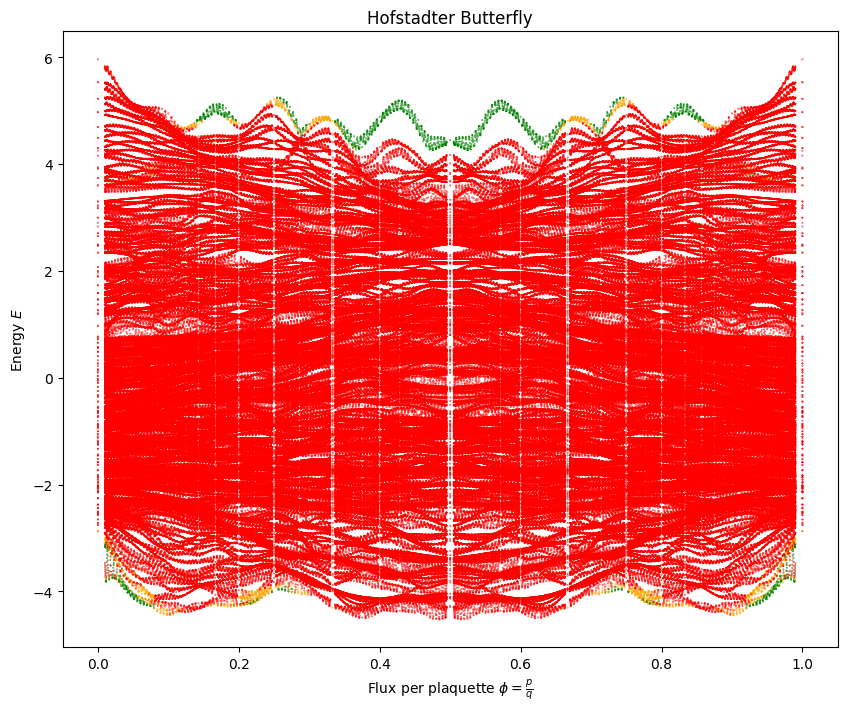

In [284]:
# Constructing the Butterfly

phis = []
energies = []
# We define bulk and boundary states Ψ by
# calculating the position expectation value in the Poincaré disk
# given by 〈r〉 = ∑ i ri|Ψ(ri)|2, assuming Ψ normalized.
# states = evecs
r_i = np.array([abs(tiling.get_center(i)) for i in range(len(tiling))])
colors = [] 
max_q = 100
for q_ in range(1, max_q + 1):
    for p_ in range(q_ + 1):
                
        if gcd(p_, q_) == 1:
            phi = p_/q_
            H = magnetic_phases_try(tiling.p, tiling.q, tiling.n, phi)
            #print("Hamiltonian =", H)
            #print("Shape of Hamiltonian:", np.shape(H))
            evals, evecs= np.linalg.eigh(H) # Reconstruct hamiltonian for each allowed phi
            r_exp = np.sum(r_i[:, None] * np.abs(evecs)**2, axis = 0)       
            for i, r in enumerate(r_exp):
                phis.append(phi)
                energies.append(evals[i])
                #phis.extend([p_ / q_] * len(evals))
                #energies.extend(evals.tolist()) 
                if 0 < r < 0.65: # bulk state 
                    colors.append('green')
                elif 0.7 < r < 1: # boundary state
                    colors.append('red')
                else:
                    colors.append('orange')

plt.figure(figsize=(10, 8))
plt.scatter(phis, energies, s=0.1, color = colors)
plt.xlabel(r'Flux per plaquette $\phi = \frac{p}{q}$')
plt.ylabel(r'Energy $E$')
plt.title("Hofstadter Butterfly")
plt.grid(False)